In [113]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import jax.numpy as jnp
import flax.linen as nn

from stanza.nets.mlp import MLP

mlp = MLP([128, 128, 10, 1])

In [115]:
import jax
from stanza.data import Data
import matplotlib.pyplot as plt

def generate_data(rng_key):
    t = jax.random.uniform(rng_key)
    y = jax.random.choice(rng_key, jnp.array([0,1]), replace=False)
    r = 2*(1 + t/2)
    o = 3*y
    x1 = r*jnp.sin(2 * jnp.pi * t + o)
    x2 = r*jnp.cos(2 * jnp.pi * t + o)
    # x1 = t
    # x2 = y
    X = jnp.stack([x1, x2])
    return X, y

data = jax.vmap(generate_data)(jax.random.split(jax.random.PRNGKey(42), 128))
val_data = jax.vmap(generate_data)(jax.random.split(jax.random.PRNGKey(44), 64))
data = Data.from_pytree(data)
val_data = Data.from_pytree(val_data)

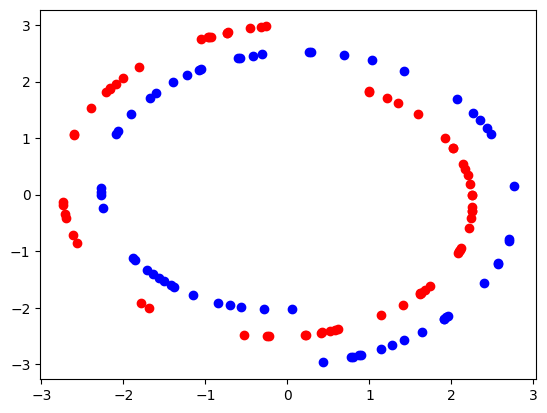

In [116]:
def plot_data(d):
    d = d.data
    X, y = d
    X0 = X[y==0,:]
    X1 = X[y==1,:]
    x0, y0 = X0[:,0], X0[:,1]
    x1, y1 = X1[:,0], X1[:,1]
    plt.plot(x0, y0, 'o', color='red')
    plt.plot(x1, y1, 'o', color='blue')
plot_data(data)
plt.show()

In [117]:
from stanza.nets.mlp import MLP
import optax

mlp = MLP([64, 32, 10, 1], "gelu")

def model(params, x):
    pred = mlp.apply(params, x)
    return jax.nn.sigmoid(pred)

def loss(state, params, rng, batch):
    X, y = batch
    y_pred = jax.vmap(mlp.apply, in_axes=(None, 0))(params, X).squeeze()
    # loss = optax.sigmoid_binary_cross_entropy(y_pred, y).mean()
    y_pred = jax.nn.sigmoid(y_pred)
    loss = jnp.square(y_pred - y).mean()
    return state, loss, {"loss": loss}

In [118]:
from stanza.train import Trainer
from stanza.util.rich import ConsoleDisplay, StatisticsTable, LoopProgress
from jax.random import PRNGKey
import optax

optimizer = optax.adamw(
    optax.cosine_decay_schedule(1e-3, 5000*10), 
    weight_decay=5e-3
)

display = ConsoleDisplay()
display.add("train", StatisticsTable(), interval=100)
display.add("train", LoopProgress(), interval=100)
trainer = Trainer(loss_fn=loss, max_iterations=5_000, batch_size=32)

with display as dh:
    init_params = mlp.init(PRNGKey(42), jnp.ones((2,)))
    results = trainer.train(data, rng_key=PRNGKey(43), init_params=init_params, train_hooks=[dh.train])
params = results.fn_params

Output()

[00:06:58] TRACE  - <Tracing> Tracing training                                                      ]8;id=126207;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=16640;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#124\124]8;;\

           TRACE  - <Tracing> Tracing epoch step                                                    ]8;id=275266;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=925448;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                                                     ]8;id=764885;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=778695;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#69\69]8;;\

           TRACE  - <Tracing> Done tracing training                                                 ]8;id=225020;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=564455;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#133\133]8;;\

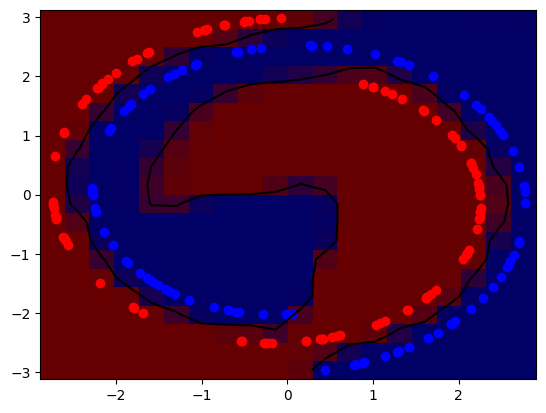

In [121]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcol

def visualize_model(params):
    X, _ = data.data
    x_min, x_max = jnp.min(X[:,0]), jnp.max(X[:,0])
    y_min, y_max = jnp.min(X[:,1]), jnp.max(X[:,1])
    x, y = jnp.meshgrid(jnp.linspace(x_min, x_max, 20), jnp.linspace(y_min, y_max, 20))
    X = jnp.stack([x.flatten(), y.flatten()], axis=-1)
    y_pred = jax.vmap(model, in_axes=(None, 0))(params, X)
    y_pred = y_pred.reshape(x.shape)
    cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",[(0.4, 0., 0.),(0., 0., 0.4)])
    plt.pcolor(x, y, y_pred, cmap=cmap, vmin=0, vmax=1)
    plt.contour(x, y, y_pred, levels=[0.5], colors='k')

plot_data(data)
plot_data(val_data)
visualize_model(params)
plt.show()

In [120]:
def accuracy(params, data):
    X, y = data.data
    y_pred = jax.vmap(model, in_axes=(None, 0))(params, X).squeeze()
    y_pred = jnp.round(y_pred)
    return (y_pred == y).mean()

print(accuracy(params, val_data))

0.50439453
